Elisa Marlow - mai 2025

# Spotify playlist generator

## Goal : Create a recommendation playlist based on 1 song.



# 0) Setup

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

#for the autoencoder part
import tensorflow as tf
import tensorflow.keras.datasets.mnist as mnist
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# a ) Loading the data

Since the data set is particularly large [114000 rows x 21 columns]
In order to work with the data, i trimmed the data set randomly

In [23]:
# Load Data
df = pd.read_csv("dataset.csv") 
print(df)
print(df.shape)

# Ensure the example song is included
example_song = df[(df['track_name'] == "I'm Yours") & (df['artists'] == "Jason Mraz")]
if not example_song.empty:
    df_sampled = df.sample(n=9999, random_state=42)
    df = pd.concat([df_sampled, example_song]).reset_index(drop=True)
else:
    df = df.sample(n=10000, random_state=42).reset_index(drop=True)

# Clean Data
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

        Unnamed: 0                track_id                 artists  \
0                0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1                1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2                2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3                3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4                4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   
...            ...                     ...                     ...   
113995      113995  2C3TZjDRiAzdyViavDJ217           Rainy Lullaby   
113996      113996  1hIz5L4IB9hN3WRYPOCGPw           Rainy Lullaby   
113997      113997  6x8ZfSoqDjuNa5SVP5QjvX           Cesária Evora   
113998      113998  2e6sXL2bYv4bSz6VTdnfLs        Michael W. Smith   
113999      113999  2hETkH7cOfqmz3LqZDHZf5           Cesária Evora   

                                               album_name  \
0                                                  Comedy   
1                                    

# b) Feature Selection and Normalization

Select audio features relevant for recommendation and normalize them to ensure fair comparison across different scales.

We drop every non digit feature.

In [24]:
# Features for recommendation
audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                  'duration_ms', 'popularity']

# Normalize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[audio_features])
df_scaled_df = pd.DataFrame(df_scaled, columns=audio_features)

# Add identifiers
df_scaled_df['track_name'] = df['track_name'].values
df_scaled_df['artist_name'] = df['artists'].values  # Updated to use 'artists' column
df_scaled_df['song_label'] = df_scaled_df['track_name'] + ' - ' + df_scaled_df['artist_name']

# c) Cosine Similarity Matrix


In [25]:

similarity_matrix = cosine_similarity(df_scaled)

def generate_playlist(target_song_name, artist_name, df_original, similarity_matrix, num_recommendations=15):
    label = f"{target_song_name} - {artist_name}"
    
    if label not in df_original['song_label'].values:
        print(f"❌ Song '{label}' not found in dataset.")
        return pd.DataFrame()
    
    target_idx = df_original[df_original['song_label'] == label].index[0]
    
    # Compute similarities
    similarities = similarity_matrix[target_idx]
    sorted_indices = np.argsort(similarities)[::-1]
    
    unique_songs = set()
    playlist_indices = []
    
    for idx in sorted_indices:
        song_label = df_original.iloc[idx]['song_label']
        if song_label != label and song_label not in unique_songs:
            unique_songs.add(song_label)
            playlist_indices.append(idx)
            if len(playlist_indices) == num_recommendations:
                break
    
    playlist = df_original.iloc[playlist_indices].copy()
    playlist['similarity'] = similarities[playlist_indices]
    
    final_playlist = playlist[['track_name', 'artist_name', 'similarity']].reset_index(drop=True)
    
    # --- Playlist-style display ---
    print(f"\n Recommended Playlist (based on '{target_song_name}' by {artist_name}) \n ")
    for idx, row in final_playlist.iterrows():
        track = row['track_name']
        artist = row['artist_name']
        similarity = f"{row['similarity']:.2f}"
        print(f"{idx+1:02d}. {track} — {artist}  (similarity: {similarity})")
    
    return final_playlist

playlist = generate_playlist("I'm Yours", "Jason Mraz", df_scaled_df, similarity_matrix)
playlist


 Recommended Playlist (based on 'I'm Yours' by Jason Mraz) 
 
01. The Weight - Remastered 2000 — The Band  (similarity: 0.94)
02. Traingazing — Sam Wills;Honey Mooncie  (similarity: 0.89)
03. Man! I Feel Like A Woman! — Shania Twain  (similarity: 0.89)
04. Talk It Out — dwsdmusic  (similarity: 0.87)
05. redesign — awfultune  (similarity: 0.87)
06. Melhor pensar — UM44K;Luan Otten  (similarity: 0.86)
07. Rocket Man (I Think It's Going To Be A Long, Long Time) — Elton John  (similarity: 0.86)
08. Passenger Seat (Acoustic) — Stephen Speaks  (similarity: 0.86)
09. Sinais — Sorriso Maroto  (similarity: 0.85)
10. dooriyan — Zaeden  (similarity: 0.84)
11. Ajab Si — KK  (similarity: 0.84)
12. Ain't No Mountain High Enough — Marvin Gaye;Tammi Terrell  (similarity: 0.84)
13. Preciso Desse Mel — Grupo Sensação  (similarity: 0.84)
14. Without Me — Halsey  (similarity: 0.82)
15. Ruin My Life — Zara Larsson  (similarity: 0.82)


,track_name,artist_name,similarity
0,The Weight - Remastered 2000,The Band,0.943701
1,Traingazing,Sam Wills;Honey Mooncie,0.889597
2,Man! I Feel Like A Woman!,Shania Twain,0.889009
3,Talk It Out,dwsdmusic,0.867523
4,redesign,awfultune,0.866475
5,Melhor pensar,UM44K;Luan Otten,0.863605
6,"Rocket Man (I Think It's Going To Be A Long, L...",Elton John,0.860924
7,Passenger Seat (Acoustic),Stephen Speaks,0.855778
8,Sinais,Sorriso Maroto,0.853800
9,dooriyan,Zaeden,0.844091


# I) Principal Components Analysis (PCA)

In [26]:
# PCA with 2 components
pca = PCA(n_components=2)
projection = pca.fit_transform(df_scaled)
df_scaled_df['pca1'] = projection[:, 0]
df_scaled_df['pca2'] = projection[:, 1]

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", sum(pca.explained_variance_ratio_))

Explained variance ratio: [0.21869924 0.11919306]
Total explained variance: 0.3378923017389101



PCA Loadings (Feature Importance):
                       PC1       PC2
danceability      0.235891  0.481773
energy            0.510688 -0.259534
key               0.042562 -0.020153
loudness          0.519404 -0.062419
mode             -0.053386  0.110091
speechiness       0.106115  0.055735
acousticness     -0.448949  0.294790
instrumentalness -0.274460 -0.346961
liveness          0.079091 -0.152393
valence           0.278587  0.510843
tempo             0.187505 -0.220674
duration_ms       0.003998 -0.372887
popularity        0.043902  0.042417


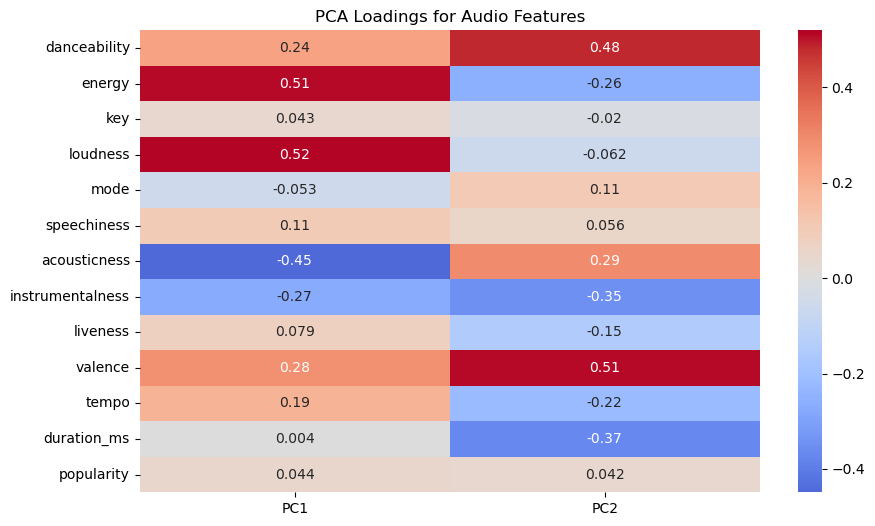

In [27]:
# Feature importance from PCA loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=audio_features)
print("\nPCA Loadings (Feature Importance):")
print(loadings)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title("PCA Loadings for Audio Features")
plt.show()

In [28]:
# Apply K-Means clustering
n_clusters = 5  # Adjust based on dataset size and experimentation
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_scaled_df['cluster'] = kmeans.fit_predict(df_scaled)

# Evaluate clustering with silhouette score
sil_score = silhouette_score(df_scaled, df_scaled_df['cluster'])
print(f"\nSilhouette Score for {n_clusters} clusters: {sil_score:.3f}")


Silhouette Score for 5 clusters: 0.107


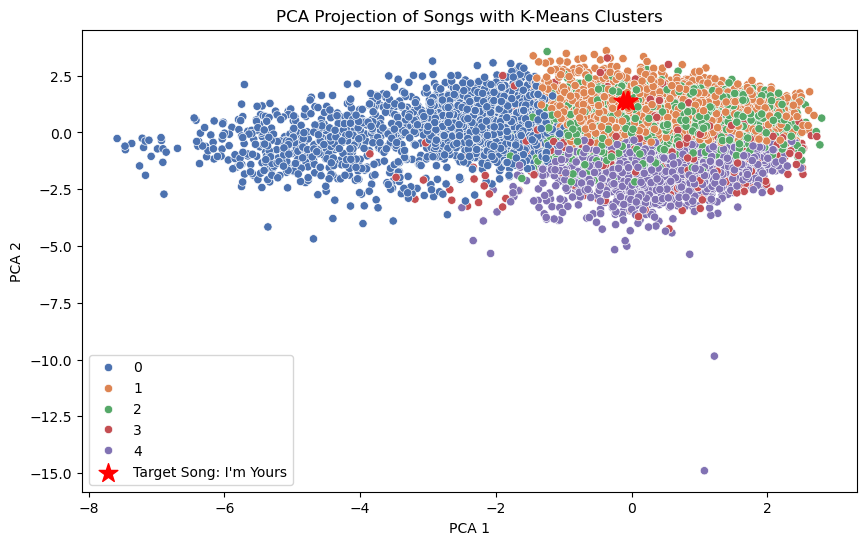

In [29]:
# Example song to highlight
target_song = "I'm Yours - Jason Mraz"
target_idx = df_scaled_df[df_scaled_df['song_label'] == target_song].index

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_scaled_df, x='pca1', y='pca2', hue='cluster', palette='deep', legend='full')
if not target_idx.empty:
    plt.scatter(df_scaled_df.loc[target_idx, 'pca1'], df_scaled_df.loc[target_idx, 'pca2'],
                c='red', s=200, marker='*', label="Target Song: I'm Yours")
plt.title("PCA Projection of Songs with K-Means Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()

## Generating the playlist using knn 2 dimensional PCA

In [30]:
from sklearn.neighbors import NearestNeighbors


def recommend_knn_2d(track_name, artist_name, df, top_n=15):
    label = f"{track_name} - {artist_name}"
    
    if label not in df['song_label'].values:
        print(f" Song '{label}' not found.")
        return pd.DataFrame()
    
    target_idx = df[df['song_label'] == label].index[0]
    feature_vector = df.loc[target_idx, ['pca1', 'pca2']].values.reshape(1, -1)
    target_cluster = df.loc[target_idx, 'cluster']
    
    knn = NearestNeighbors(n_neighbors=top_n*3, metric='euclidean')
    knn.fit(df[['pca1', 'pca2']].values)
    
    distances, indices = knn.kneighbors(feature_vector)
    recommendations = df.iloc[indices[0][1:]].copy()
    recommendations.loc[:, 'similarity'] = 1 / (1 + distances[0][1:])
    recommendations = recommendations.drop_duplicates(
        subset=['track_name', 'artist_name'],
        keep='first'
    )
    
    same_cluster = recommendations[recommendations['cluster'] == target_cluster]
    other_clusters = recommendations[recommendations['cluster'] != target_cluster]
    
    final_recommendations = pd.concat([
        same_cluster.sort_values('similarity', ascending=False),
        other_clusters.sort_values('similarity', ascending=False)
    ]).head(top_n).reset_index(drop=True)
    
    print(f"\n Recommended Playlist (based on '{track_name}' by {artist_name}) \n ")
    for idx, row in final_recommendations.iterrows():
        track = row['track_name']
        artist = row['artist_name']
        similarity = f"{row['similarity']:.2f}"
        cluster = row['cluster']
        print(f"{idx+1:02d}. {track} — {artist}  (similarity: {similarity}, cluster: {cluster})")
    
    return final_recommendations

recommendations = recommend_knn_2d("I'm Yours", "Jason Mraz", df_scaled_df)


 Recommended Playlist (based on 'I'm Yours' by Jason Mraz) 
 
01. I'm Yours — Jason Mraz  (similarity: 1.00, cluster: 1)
02. Boca Ciega — Jesse Rice  (similarity: 0.96, cluster: 1)
03. Raataan Lambiyan (From "Shershaah") — Tanishk Bagchi;Jubin Nautiyal;Asees Kaur  (similarity: 0.94, cluster: 1)
04. Para un Viejo Corazón — Dúo Ayacucho  (similarity: 0.93, cluster: 1)
05. Introvert — Takeova  (similarity: 0.93, cluster: 1)
06. Heat Waves — Glass Animals  (similarity: 0.93, cluster: 1)
07. Acéptame Como Soy — Manoella Torres  (similarity: 0.93, cluster: 1)
08. Abrazándonos — Abel Pintos  (similarity: 0.92, cluster: 1)
09. Bitte Geh Nicht — Vanessa Mai  (similarity: 0.91, cluster: 1)
10. Merry Christmas — Bryan Adams  (similarity: 0.90, cluster: 1)
11. New Delhi — HXGO  (similarity: 0.90, cluster: 1)
12. Co2 — Prateek Kuhad  (similarity: 0.90, cluster: 1)
13. She Was Playing Too — Terry Wright  (similarity: 0.90, cluster: 1)
14. Marigold — The Ocean Blue  (similarity: 0.89, cluster: 1)
15

In [31]:
#initialisation df_scalled_df
# Normalize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[audio_features])
df_scaled_df = pd.DataFrame(df_scaled, columns=audio_features)

# Add identifiers
df_scaled_df['track_name'] = df['track_name'].values
df_scaled_df['artist_name'] = df['artists'].values  # Updated to use 'artists' column
df_scaled_df['song_label'] = df_scaled_df['track_name'] + ' - ' + df_scaled_df['artist_name']

In [32]:
# PCA with 3 components
pca = PCA(n_components=3)
projection = pca.fit_transform(df_scaled)
df_scaled_df['pca1'] = projection[:, 0]
df_scaled_df['pca2'] = projection[:, 1]
df_scaled_df['pca3'] = projection[:, 2]  # Add the third component

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", sum(pca.explained_variance_ratio_))


Explained variance ratio: [0.21869924 0.11919306 0.09733035]
Total explained variance: 0.4352226499356978



PCA Loadings (Feature Importance):
                       PC1       PC2       PC3
danceability      0.235891  0.481773 -0.248977
energy            0.510688 -0.259534  0.042987
key               0.042562 -0.020153 -0.126412
loudness          0.519404 -0.062419 -0.018901
mode             -0.053386  0.110091  0.212527
speechiness       0.106115  0.055735  0.554973
acousticness     -0.448949  0.294790  0.187379
instrumentalness -0.274460 -0.346961 -0.176870
liveness          0.079091 -0.152393  0.674275
valence           0.278587  0.510843 -0.020562
tempo             0.187505 -0.220674 -0.014093
duration_ms       0.003998 -0.372887 -0.189452
popularity        0.043902  0.042417 -0.095444


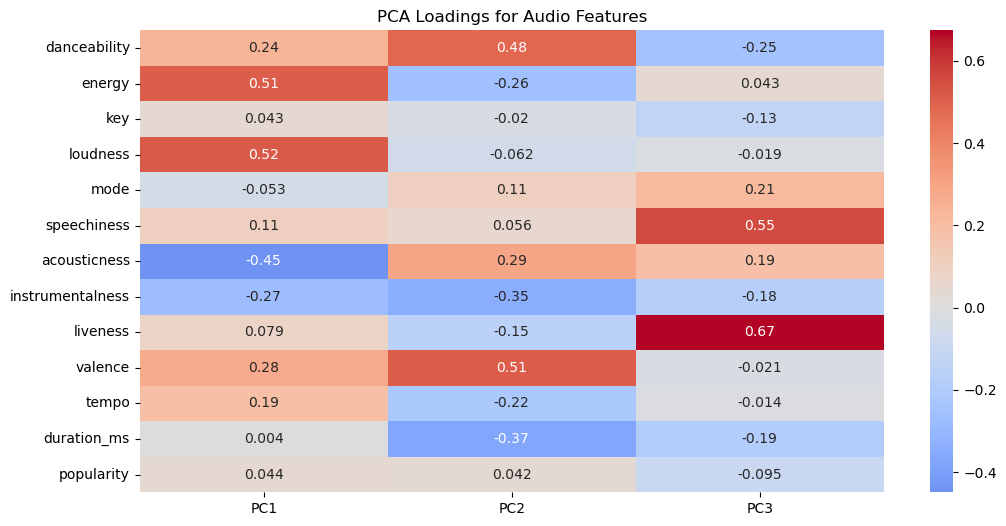


Silhouette Score for 5 clusters: 0.107


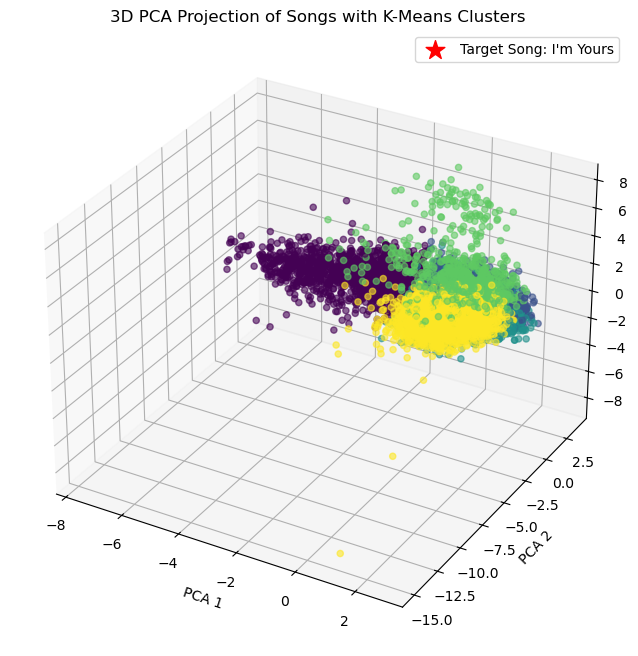

In [33]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=audio_features)
print("\nPCA Loadings (Feature Importance):")
print(loadings)
plt.figure(figsize=(12, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title("PCA Loadings for Audio Features")
plt.show()

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_scaled_df['cluster'] = kmeans.fit_predict(df_scaled)

sil_score = silhouette_score(df_scaled, df_scaled_df['cluster'])
print(f"\nSilhouette Score for {n_clusters} clusters: {sil_score:.3f}")

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_scaled_df['pca1'], 
    df_scaled_df['pca2'], 
    df_scaled_df['pca3'], 
    c=df_scaled_df['cluster'], 
    cmap='viridis',
    alpha=0.6
)

target_song = "I'm Yours - Jason Mraz"
target_idx = df_scaled_df[df_scaled_df['song_label'] == target_song].index
if not target_idx.empty:
    ax.scatter(
        df_scaled_df.loc[target_idx, 'pca1'],
        df_scaled_df.loc[target_idx, 'pca2'],
        df_scaled_df.loc[target_idx, 'pca3'],
        c='red',
        s=200,
        marker='*',
        label='Target Song: I\'m Yours'
    )

ax.set_title("3D PCA Projection of Songs with K-Means Clusters")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.legend()
plt.show()

In [37]:
from sklearn.neighbors import NearestNeighbors

def recommend_knn_3d(track_name, artist_name, df, top_n=15):
    label = f"{track_name} - {artist_name}"
    
    if label not in df['song_label'].values:
        print(f" Song '{label}' not found.")
        return pd.DataFrame()
    
    target_idx = df[df['song_label'] == label].index[0]
    target_coords = df.loc[target_idx, ['pca1', 'pca2', 'pca3']].values.reshape(1, -1)
    target_cluster = df.loc[target_idx, 'cluster']
    
    knn = NearestNeighbors(n_neighbors=top_n*3, metric='euclidean')
    knn.fit(df[['pca1', 'pca2', 'pca3']].values)
    
    distances, indices = knn.kneighbors(target_coords)
    
    recommendations = df.iloc[indices[0][1:]].copy()
    
    recommendations.loc[:, 'similarity'] = 1 / (1 + distances[0][1:])
    
    recommendations = recommendations.drop_duplicates(
        subset=['track_name', 'artist_name'],
        keep='first'
    )
    
    same_cluster = recommendations[recommendations['cluster'] == target_cluster]
    other_clusters = recommendations[recommendations['cluster'] != target_cluster]
    
    final_recommendations = pd.concat([
        same_cluster.sort_values('similarity', ascending=False),
        other_clusters.sort_values('similarity', ascending=False)
    ]).head(top_n).reset_index(drop=True)
    
    # --- Playlist-style display ---
    print(f"\n Recommended Playlist (based on '{track_name}' by {artist_name}) \n ")
    for idx, row in final_recommendations.iterrows():
        track = row['track_name']
        artist = row['artist_name']
        similarity = f"{row['similarity']:.2f}"
        cluster = row['cluster']
        print(f"{idx+1:02d}. {track} — {artist}  (similarity: {similarity}, cluster: {cluster})")
    
    return final_recommendations

recommendations = recommend_knn_3d("I'm Yours", "Jason Mraz", df_scaled_df)


 Recommended Playlist (based on 'I'm Yours' by Jason Mraz) 
 
01. I'm Yours — Jason Mraz  (similarity: 1.00, cluster: 1)
02. Marigold — The Ocean Blue  (similarity: 0.85, cluster: 1)
03. Raataan Lambiyan (From "Shershaah") — Tanishk Bagchi;Jubin Nautiyal;Asees Kaur  (similarity: 0.84, cluster: 1)
04. Been down so Long — The Doors  (similarity: 0.78, cluster: 1)
05. Heart Of Glass - Special Mix — Blondie  (similarity: 0.78, cluster: 1)
06. Jogi — Yasser Desai;Aakanksha Sharma  (similarity: 0.78, cluster: 1)
07. Acéptame Como Soy — Manoella Torres  (similarity: 0.77, cluster: 1)
08. Voh Dekhnay Mein — Ali Zafar  (similarity: 0.77, cluster: 1)
09. Manavaalan Thug - From "Thallumaala" — Dabzee;SA  (similarity: 0.76, cluster: 1)
10. Fuiste un Trozo de Hielo en la Escarcha — Juanafé;Demian Rodríguez  (similarity: 0.75, cluster: 1)
11. She Was Playing Too — Terry Wright  (similarity: 0.73, cluster: 1)
12. Apasionadamente — Maelo Ruiz  (similarity: 0.73, cluster: 1)
13. Tequila — The Champs  

## 2) Using Autoencoders for dimensionality reduction


In [38]:
#initialisation df_scalled_df
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[audio_features])
df_scaled_df = pd.DataFrame(df_scaled, columns=audio_features)

#identifiers
df_scaled_df['track_name'] = df['track_name'].values
df_scaled_df['artist_name'] = df['artists'].values  # Updated to use 'artists' column
df_scaled_df['song_label'] = df_scaled_df['track_name'] + ' - ' + df_scaled_df['artist_name']

In [39]:
def nonlinear_autoencoder(input_size, code_size: int):
    """
    Instanciate and compiles an autoencoder, returns both the autoencoder and just the encoder

    :param int or tuple input_size: shape of the input samples
    :param int code_size: dimension on which to project the original data
    :return: autoencoder, encoder
    """
    input_layer = Input(shape=(input_size,))
    hidden_layer_input = Dense(input_size//4, activation = 'relu')(input_layer)
    encoder_layer = Dense(code_size, activation = 'relu')(hidden_layer_input)
    hidden_layer_output = Dense(input_size//4, activation = 'relu')(encoder_layer)
    decoder_layer = Dense(input_size)(hidden_layer_output)
    autoencoder = Model(inputs = input_layer, outputs = decoder_layer)
    autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')
    encoder = Model(inputs = input_layer, outputs = encoder_layer)
    
    return autoencoder, encoder

In [40]:
# define and train Autoencoder
input_dim = len(audio_features)  # 12 features
encoding_dim = 2  # 2D latent space
autoencoder, encoder = nonlinear_autoencoder(input_dim, encoding_dim)
autoencoder.fit(df_scaled, df_scaled, epochs=50, batch_size=32, shuffle=True, verbose=1)

# 2D Latent Representations
latent_representation = encoder.predict(df_scaled)
df_scaled_df['latent1'] = latent_representation[:, 0]
df_scaled_df['latent2'] = latent_representation[:, 1]

# reconstruction loss
reconstruction_loss = autoencoder.evaluate(df_scaled, df_scaled, verbose=0)
print(f"\nAutoencoder Reconstruction Loss (MSE): {reconstruction_loss:.4f}")

I0000 00:00:1758616342.780547 1085809 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14108 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/50


I0000 00:00:1758616343.499849 1086596 service.cc:152] XLA service 0x7f663800b350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758616343.499863 1086596 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-09-23 10:32:23.511116: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758616343.583848 1086596 cuda_dnn.cc:529] Loaded cuDNN version 90501


193/313 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 1.0008

I0000 00:00:1758616344.252398 1086596 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9943
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 0.8930
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 0.7531
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 0.7245
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 0.6936
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.6773
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 0.6849
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.6577
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 0.6645
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.6567
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6715
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 0.6580
Epoch 13/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.6790
Epoch 14/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 0.6576
Epoch 15/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [41]:
#K-Means Clustering on Latent Representations
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_scaled_df['cluster'] = kmeans.fit_predict(latent_representation)

# Evaluate Clustering
sil_score = silhouette_score(latent_representation, df_scaled_df['cluster'])
print(f"Silhouette Score for {n_clusters} clusters: {sil_score:.3f}")

Silhouette Score for 5 clusters: 0.319


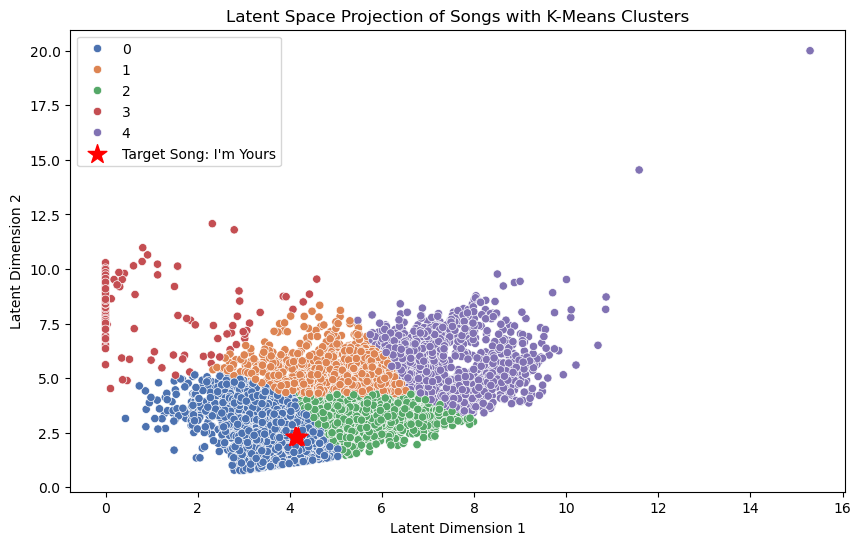

In [43]:
# sample data to reduce memory usage
sample_size = 10000
target_song_label = "I'm Yours - Jason Mraz"

# visualization of the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_scaled_df, x='latent1', y='latent2', hue='cluster', palette='deep', legend='full')
target_idx = df_scaled_df[df_scaled_df['song_label'] == target_song_label].index
if not target_idx.empty:
    plt.scatter(df_scaled_df.loc[target_idx, 'latent1'], df_scaled_df.loc[target_idx, 'latent2'],
                c='red', s=200, marker='*', label="Target Song: I'm Yours")
plt.title("Latent Space Projection of Songs with K-Means Clusters")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()

In [44]:
def recommend(track_name, artist_name, df, sim_matrix, top_n=15):
    label = f"{track_name} - {artist_name}"
    
    if label not in df['song_label'].values:
        print(f" Song '{label}' not found in sampled dataset.")
        return pd.DataFrame()
    
    idx = df[df['song_label'] == label].index[0]
    target_cluster = df.loc[idx, 'cluster']
    
    df['similarity'] = sim_matrix[idx]
    
    recommendations = df[(df['song_label'] != label) & (df['cluster'] == target_cluster)] \
        .sort_values(by='similarity', ascending=False) \
        .head(top_n)
    
    if len(recommendations) < top_n:
        additional = df[(df['song_label'] != label) & (df['cluster'] != target_cluster)] \
            .sort_values(by='similarity', ascending=False) \
            .head(top_n - len(recommendations))
        recommendations = pd.concat([recommendations, additional])
    
    final_recommendations = recommendations[['track_name', 'artist_name', 'similarity', 'cluster']].reset_index(drop=True)
    
    # --- Playlist-style display ---
    print(f"\n Recommended Playlist (based on '{track_name}' by {artist_name}) \n ")
    for idx, row in final_recommendations.iterrows():
        track = row['track_name']
        artist = row['artist_name']
        similarity = f"{row['similarity']:.2f}"
        cluster = row['cluster']
        print(f"{idx+1:02d}. {track} — {artist}  (similarity: {similarity}, cluster: {cluster})")
    
    return final_recommendations


In [45]:
recommendations = recommend("I'm Yours", "Jason Mraz", df_scaled_df, similarity_matrix)


 Recommended Playlist (based on 'I'm Yours' by Jason Mraz) 
 
01. Traingazing — Sam Wills;Honey Mooncie  (similarity: 0.89, cluster: 0)
02. Man! I Feel Like A Woman! — Shania Twain  (similarity: 0.89, cluster: 0)
03. Talk It Out — dwsdmusic  (similarity: 0.87, cluster: 0)
04. redesign — awfultune  (similarity: 0.87, cluster: 0)
05. Melhor pensar — UM44K;Luan Otten  (similarity: 0.86, cluster: 0)
06. Sinais — Sorriso Maroto  (similarity: 0.85, cluster: 0)
07. dooriyan — Zaeden  (similarity: 0.84, cluster: 0)
08. Ajab Si — KK  (similarity: 0.84, cluster: 0)
09. Ain't No Mountain High Enough — Marvin Gaye;Tammi Terrell  (similarity: 0.84, cluster: 0)
10. Preciso Desse Mel — Grupo Sensação  (similarity: 0.84, cluster: 0)
11. Without Me — Halsey  (similarity: 0.82, cluster: 0)
12. Ruin My Life — Zara Larsson  (similarity: 0.82, cluster: 0)
13. Blueberry Hill — Fats Domino  (similarity: 0.82, cluster: 0)
14. Main Ki Karaan? (From "Laal Singh Chaddha") — Pritam;Sonu Nigam;Romy  (similarity: 

In [46]:
def recommend_knn_2d_autoencoder(track_name, artist_name, df, top_n=15):
    """
    Generate recommendations using KNN on 2D latent space from autoencoder
    and display them in a formatted playlist style.
    
    Args:
        track_name (str): Name of target track
        artist_name (str): Name of target artist
        df (pd.DataFrame): DataFrame containing latent features and metadata
        top_n (int): Number of recommendations to return
        
    Returns:
        pd.DataFrame: Recommended songs with similarity scores
    """
    label = f"{track_name} - {artist_name}"
    
    if label not in df['song_label'].values:
        print(f" Song '{label}' not found.")
        return pd.DataFrame()
    
    target_idx = df[df['song_label'] == label].index[0]
    target_coords = df.loc[target_idx, ['latent1', 'latent2']].values.reshape(1, -1)
    target_cluster = df.loc[target_idx, 'cluster']
    
    knn = NearestNeighbors(n_neighbors=top_n*3, metric='euclidean')
    knn.fit(df[['latent1', 'latent2']].values)
    
    distances, indices = knn.kneighbors(target_coords)
    
    recommendations = df.iloc[indices[0][1:]].copy()  # Skip query song
    
    recommendations.loc[:, 'similarity'] = 1 / (1 + distances[0][1:])
    
    recommendations = recommendations.drop_duplicates(
        subset=['track_name', 'artist_name'],
        keep='first'
    )
    
    same_cluster = recommendations[recommendations['cluster'] == target_cluster]
    other_clusters = recommendations[recommendations['cluster'] != target_cluster]
    
    final_recommendations = pd.concat([
        same_cluster.sort_values('similarity', ascending=False),
        other_clusters.sort_values('similarity', ascending=False)
    ]).head(top_n).reset_index(drop=True)
    
    # --- Playlist-style display ---
    print(f"\n Recommended Playlist (based on '{track_name}' by {artist_name}) \n ")
    for idx, row in final_recommendations.iterrows():
        track = row['track_name']
        artist = row['artist_name']
        similarity = f"{row['similarity']:.2f}"
        cluster = row['cluster']
        print(f"{idx+1:02d}. {track} — {artist}  (similarity: {similarity}, cluster: {cluster})")
    
    return final_recommendations[['track_name', 'artist_name', 'similarity', 'cluster']]

recommendations = recommend_knn_2d_autoencoder("I'm Yours", "Jason Mraz", df_scaled_df)


 Recommended Playlist (based on 'I'm Yours' by Jason Mraz) 
 
01. I'm Yours — Jason Mraz  (similarity: 1.00, cluster: 0)
02. Enganchate Conmigo — Andrés Calamaro;Juanes;Niño Josele  (similarity: 0.96, cluster: 0)
03. 夢想號黃包車 — Jenny Tseng  (similarity: 0.95, cluster: 0)
04. Si Supieras — Orquesta Internacional Los Niches  (similarity: 0.95, cluster: 0)
05. Marigold — The Ocean Blue  (similarity: 0.94, cluster: 0)
06. sex money feelings die - slowed version — Lykke Li  (similarity: 0.94, cluster: 0)
07. Always Look On The Bright Side Of Life — Monty Python  (similarity: 0.94, cluster: 0)
08. Co2 — Prateek Kuhad  (similarity: 0.94, cluster: 0)
09. Bitte Geh Nicht — Vanessa Mai  (similarity: 0.93, cluster: 0)
10. Seja Mais Você — Grupo Raça  (similarity: 0.93, cluster: 0)
11. Acéptame Como Soy — Manoella Torres  (similarity: 0.93, cluster: 0)
12. Raataan Lambiyan (From "Shershaah") — Tanishk Bagchi;Jubin Nautiyal;Asees Kaur  (similarity: 0.93, cluster: 0)
13. Amarroto — Juan D'Arienzo;Alb